<a href="https://colab.research.google.com/github/Dunckleosteus/seismic/blob/dominus/seismic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
!rm data.zip
!rm -r data
!wget https://github.com/Dunckleosteus/seismic/raw/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip
!unzip data.zip

--2025-03-19 10:57:44--  https://github.com/Dunckleosteus/seismic/raw/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Dunckleosteus/seismic/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip [following]
--2025-03-19 10:57:45--  https://raw.githubusercontent.com/Dunckleosteus/seismic/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1512 (1.5K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1.48K  --.-KB/s    in 0s      

2025-03-19 10:57:45 (18.9 MB/s) - ‘da

In [6]:
rhob = pd.read_csv('data/rhob.csv', index_col=0)
rhob

,0;2300,0;2300.1,0;2300.2,0;2300.3,0;2300.4,0;2300.5,0;2300.6,0;2300.7,0;2300.8,0;2300.9,...,0;2300.21,0;2300.22,0;2300.23,0;2300.24,0;2300.25,0;2300.26,0;2300.27,0;2300.28,0;2300.29,0
2300,,,,,,,,,,,,,,,,,,,,,
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0
2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,...,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0;2300,0


In [9]:

df_path_list = [
    "data/rhob.csv",
    "data/vph.csv",
    "data/x.csv",
    "data/y.csv",

]
df_list = [pd.read_csv(path, index_col=None, header=None, sep=";") for path in df_path_list]
[df.dropna(inplace=True) for df in df_list]
for df in df_list:
  for col in df.columns:
    try:
      df[col] = df[col].str.replace(",", ".").astype(float).values
    except:
      df.values

array = np.stack(df_list)
array.shape

(4, 13, 31)

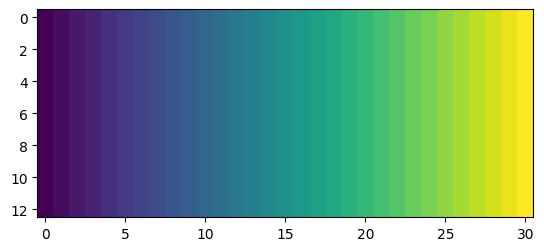

In [11]:
plt.imshow(array[2, :, :])

# Accoustic impedance
The formula for accoustic impedance is :
$$I_i=\rho_i \times v_i$$

So to calculate it, we simply need to multiply the first layer in array to the second one.

In [ ]:
plt.imshow(array[0, :, :] * array[1, :, :])
plt.title("Accoustic impedance")